#### Importar librerías 

In [88]:
import os 
from pyspark.sql import functions as f, SparkSession, types as t
from pyspark.sql.functions import lit
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import udf, col, length, isnan, when, count, regexp_replace
import mysql.connector
from pyspark.sql.window import Window
from datetime import datetime
from pyspark.sql.types import NumericType, DateType, StringType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, max
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Conexión a fuente de datos


In [2]:
source_db_connection_string = 'jdbc:mysql://157.253.236.120:8080/RaSaTransaccional'

# Driver de conexion
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Configuración servidor base de datos transaccional
# Utilizar el usuario asignado en el curso
db_user = 'Estudiante_19_202413'
db_psswd = 'aabb1122'
db_proyecto = 'RaSaTransaccional'

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

def guardar_db(db_connection_string, df, tabla, db_user, db_psswd):
    df.select('*').write.format('jdbc') \
      .mode('append') \
      .option('url', db_connection_string) \
      .option('dbtable', tabla) \
      .option('user', db_user) \
      .option('password', db_psswd) \
      .option('driver', 'com.mysql.cj.jdbc.Driver') \
      .save()

#### Cargue de las cuatro tablas que se tienen para el proyecto

In [6]:
areas_servicio = obtener_dataframe_de_bd(source_db_connection_string, 'RaSaTransaccional.FuenteAreasDeServicio_Copia_E', db_user, db_psswd)
condiciones_pago = obtener_dataframe_de_bd(source_db_connection_string, 'RaSaTransaccional.FuenteCondicionesDePago_Copia_E', db_user, db_psswd)
planes_beneficio = obtener_dataframe_de_bd(source_db_connection_string, 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E', db_user, db_psswd)
tipos_beneficio = obtener_dataframe_de_bd(source_db_connection_string, 'RaSaTransaccional.FuenteTiposBeneficio_Copia_E', db_user, db_psswd)

## Perfilamiento de los datos

#### Tabla Areas de servicio

In [18]:
areas_servicio.show(5)

+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|          Condado|    Estado|PoblacionAct| Area|Densidad|Fecha|
+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
|         100622017|New Jersey - Medi...|        34005|Burlington County|New Jersey|    464269.0|805.0|   577.0| 2017|
|         101012018|New Jersey - Medi...|        34031|   Passaic County|New Jersey|    518117.0|185.0|  2801.0| 2018|
|          10132017|BlueOptions16842F...|        12031|     Duval County|   Florida|    999935.0|774.0|  1292.0| 2017|
|         101982018|New Jersey - Medi...|        34003|    Bergen County|New Jersey|    953819.0|234.0|  4076.0| 2018|
|         102012017|New Jersey - Medi...|        34021|    Mercer County|New Jersey|    385898.0|226.0|  1708.0| 2017|
+------------------+--------------------+-------

In [17]:
areas_servicio.printSchema()

root
 |-- IdAreaDeServicio_T: integer (nullable = true)
 |-- NombreAreaDeServicio: string (nullable = true)
 |-- IdGeografia_T: integer (nullable = true)
 |-- Condado: string (nullable = true)
 |-- Estado: string (nullable = true)
 |-- PoblacionAct: double (nullable = true)
 |-- Area: double (nullable = true)
 |-- Densidad: double (nullable = true)
 |-- Fecha: integer (nullable = true)



La tabla fuente areas de servicio contiene información sobre diferentes áreas de servicio en varios condados y estados, junto con detalles demográficos y geográficos asociados.
Para la variable fecha se encuentra solo el año almacenado, es de importancia saber si está bien estructurado este campo.

Se tiene como identificador unico IdAreaDeServicio_T y IdGeografia_T


#### Tabla Condiciones de pago


In [8]:
condiciones_pago.show(5)


+---------------------+--------------------+--------+
|IdCondicionesDePago_T|         Descripcion|    Tipo|
+---------------------+--------------------+--------+
|                  187|Copay with deduct...|  Copago|
|                  204|       Copay per Day|  Copago|
|                   45|         Coinsurance|Coseguro|
|                   85|Copay per Day bef...|  Copago|
|                   18|No Charge after d...|Coseguro|
+---------------------+--------------------+--------+
only showing top 5 rows



In [16]:
condiciones_pago.printSchema()

root
 |-- IdCondicionesDePago_T: integer (nullable = true)
 |-- Descripcion: string (nullable = true)
 |-- Tipo: string (nullable = true)



Contiene información sobre diferentes condiciones de pago relacionadas con servicios médicos, se tiene como identificador unico idCondicionesDePago_T para cada condición de pago, representado como un entero.

#### Tabla Planes beneficio

In [50]:
planes_beneficio.show(5)


+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|              640|          10382017|                       34|                         27|                3|16842FL0070128-03|2017-12-31|        16842|          0|           50|            35|
|              225|          31512017|                      238|                         45|                2|29418TX0140002-04|2017-12-31|        29418|          0|            0|          null|
|              190|      

In [15]:
planes_beneficio.printSchema()

root
 |-- IdTipoBeneficio_T: long (nullable = true)
 |-- IdAreaDeServicio_T: long (nullable = true)
 |-- IdCondicionDePagoCopago_T: integer (nullable = true)
 |-- IdCondicionDePagoCoseguro_T: integer (nullable = true)
 |-- IdNivelServicio_T: integer (nullable = true)
 |-- IdPlan_T: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- IdProveedor_T: integer (nullable = true)
 |-- valorCopago: integer (nullable = true)
 |-- valorCoseguro: integer (nullable = true)
 |-- cantidadLimite: integer (nullable = true)



Se puede observar que para el campo Fecha, no se tiene estructurado el campo en formato de fecha

In [40]:
tipos_beneficio.show(5)

+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|IdTipoBeneficio_T|              Nombre|     UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|
+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|              565|Nutritional Couns...|                    |   No|                  Yes|                     No|                                      No|                                    Yes| 2017|
|              795|Rehabilitative Sp...|Days per Benefit ...|  Yes|                  Yes|                    Yes|                                      No|                                    Yes| 2

In [41]:
tipos_beneficio.printSchema()

root
 |-- IdTipoBeneficio_T: integer (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- UnidadDelLimite: string (nullable = true)
 |-- EsEHB: string (nullable = true)
 |-- EstaCubiertaPorSeguro: string (nullable = true)
 |-- TieneLimiteCuantitativo: string (nullable = true)
 |-- ExcluidoDelDesembolsoMaximoDentroDeLaRed: string (nullable = true)
 |-- ExcluidoDelDesembolsoMaximoFueraDeLaRed: string (nullable = true)
 |-- Fecha: integer (nullable = true)



**¿Cuantos datos nos compartieron para el proyecto?**

In [12]:
def contar_tipos_columnas(df):
    numericas = len([c for c in df.schema if isinstance(c.dataType, NumericType)])
    fechas = len([c for c in df.schema if isinstance(c.dataType, DateType)])
    caracteres = len([c for c in df.schema if isinstance(c.dataType, StringType)])
    return numericas, fechas, caracteres

tablas = ["Areas de servicio", "Condiciones de pago", "Planes beneficio", "Tipos de beneficio"]
objetos = [areas_servicio, condiciones_pago, planes_beneficio, tipos_beneficio]

for tabla, obj in zip(tablas, objetos):
    numericas, fechas, caracteres = contar_tipos_columnas(obj)
    print(f"Tabla '{tabla}': {obj.count()} filas, {len(obj.columns)} columnas - Numéricas: {numericas}, Fechas: {fechas}, Caracteres: {caracteres}")


Tabla 'Areas de servicio': 188815 filas, 9 columnas - Numéricas: 6, Fechas: 0, Caracteres: 3
Tabla 'Condiciones de pago': 31 filas, 3 columnas - Numéricas: 1, Fechas: 0, Caracteres: 2
Tabla 'Planes beneficio': 36036 filas, 11 columnas - Numéricas: 9, Fechas: 0, Caracteres: 2
Tabla 'Tipos de beneficio': 849 filas, 9 columnas - Numéricas: 2, Fechas: 0, Caracteres: 7


* Para la tabla area de servicio se cuenta con 188.815 registros, con nueve columnas de las cuales seis son númericas y tres son de tipo caracter, teniendo encuenta el diccionario de datos falta estructurar el formato tipo fecha para el campo "Fecha".
* Para la tabla de condiciones de pagoo se puede observar un total de 31 registros con tres columnas que son una númerica y dos de tipo caracter.
* Para la tabla planes beneficio se tiene un total de 36.036 registros, que contiene 11 columnas de las cuales nueve son numericas y dos de tipo caracter, con esto se pudo encontrar que para el campo "Fecha" no se tiene estructurado en formato DateType.
* Para la tabla tipos de beneficio se tiene un total de 849 registros, que contiene nueve collumnas de las cuales dos son numericas y siete son de tipo caracter, con esto se pudo encontrar que para el campo "Fecha" no se tiene estructurado en formato DateType.

In [13]:
def contar_duplicados_unicos(df):
    total_count = df.count()
    distinct_count = df.distinct().count()
    num_duplicados = total_count - distinct_count
    num_unicos = distinct_count
    return total_count, num_duplicados, num_unicos

tablas = ["Areas de servicio", "Condiciones de pago", "Planes beneficio", "Tipos de beneficio"]
objetos = [areas_servicio, condiciones_pago, planes_beneficio, tipos_beneficio]

for tabla, obj in zip(tablas, objetos):
    total_count, num_duplicados, num_unicos = contar_duplicados_unicos(obj)
    print(f"Tabla '{tabla}': {total_count} filas, {len(obj.columns)} columnas")
    print(f" {num_duplicados} registros duplicados, {num_unicos} registros únicos\n")



Tabla 'Areas de servicio': 188815 filas, 9 columnas
 43573 registros duplicados, 145242 registros únicos

Tabla 'Condiciones de pago': 31 filas, 3 columnas
 7 registros duplicados, 24 registros únicos

Tabla 'Planes beneficio': 36036 filas, 11 columnas
 8493 registros duplicados, 27543 registros únicos

Tabla 'Tipos de beneficio': 849 filas, 9 columnas
 271 registros duplicados, 578 registros únicos



Debido al resultado anterior, se quitan los duplicados ya que esto a futuro puede generar inconsistencias y deficiencias en la calidad de datos

In [14]:
areas_servicio_d = areas_servicio.distinct()
condiciones_pago_d = condiciones_pago.distinct()
planes_beneficio_d = planes_beneficio.distinct()
tipos_beneficio_d = tipos_beneficio.distinct()

### Revisión de reglas de negocio 


##### 1.  Las áreas de servicios reportadas cubren todos los condados del país

Para hacer la correspondiente validación se corrobora el cumplimiento de la regla tomando de "United States Census Bureau - Geography" se tienen 3144 condados.

In [46]:
# se hace revisión de la cantidad de condados que se tienen en la base de datos
print(f"Total de registros únicos por Condado: {areas_servicio_d.select('Condado').distinct().count()}")


Total de registros únicos por Condado: 1398


Ahora, se debe validar por año, cuantos servicios se tuvieron para poder validar el cumplimiento de la regla:

In [47]:
agrupado_por_fecha_y_condado = areas_servicio_d.groupBy("Fecha").agg(F.countDistinct("Condado").alias("Distintos Condadosb"))

agrupado_por_fecha_y_condado.show()


+-----+-------------------+
|Fecha|Distintos Condadosb|
+-----+-------------------+
| 2018|               1215|
| 1800|                987|
| 2017|               1020|
+-----+-------------------+



Como se puede observar no existe un cumplimiento sobre esta regla de negocio debido a que en ningunos de los años se evidencia el total de cubrimiento de lo 3144 condados que tiene Estados Unidos. Adicionalmente ya se puede notar una inconsistencia con la fecha debido a que hay información de 1800.

##### 2. Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen.

In [49]:
#Contar limite cuantitativo
tipos_beneficio_d.groupBy("TieneLimiteCuantitativo").count().show()


+-----------------------+-----+
|TieneLimiteCuantitativo|count|
+-----------------------+-----+
|                   Nein|   18|
|                     No|  340|
|                    Yes|  210|
|                     Si|   10|
+-----------------------+-----+



In [53]:
# Unir las tablas planes_beneficio y tipos_beneficio en el campo IdTipoBeneficio_T
planes_beneficio_con_limites = planes_beneficio_d.join(tipos_beneficio_d, on="IdTipoBeneficio_T", how="inner")
planes_beneficio_con_limites.show(5)

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+--------------------+---------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|              Nombre|UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+--------------------+---------------+-----+---------------------

In [54]:
# Filtrar  Yes si y cantidadLimite es 0 o NULL
beneficios_con_errores = planes_beneficio_con_limites.filter(
    ((col("TieneLimiteCuantitativo") == "Yes")|(col("TieneLimiteCuantitativo") == "Si")) & 
    ((col("cantidadLimite") == 0) | (col("cantidadLimite").isNull())))

In [56]:
# Contar el numero de beneficios con errores
print(f"Número de beneficios con errores: {beneficios_con_errores.count()}")

Número de beneficios con errores: 42203


Se puede observar inicialemnte que el limite cuantitativo tiene 4 opciones, por lo que el primer ajuste y consejo es estandarizar estas opciones. Al relizar el correspondiente filtro con los planes que tuvierna limite cuantitativo se pudo encontrar que 42.203 registros no cumplen con esta condición

##### 3.	Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019

In [63]:
# Filtrar los datos 
areas_servicio_filtered = areas_servicio_d.filter(col("Fecha").between(2017, 2019))

areas_servicio_filtered.groupBy("Fecha").count().show()


+-----+-----+
|Fecha|count|
+-----+-----+
| 2018|64083|
| 2017|76318|
+-----+-----+



In [64]:
tipos_beneficio_filtered = tipos_beneficio_d.filter(col("Fecha").between(2017, 2019))
tipos_beneficio_filtered.groupBy("Fecha").count().show()


+-----+-----+
|Fecha|count|
+-----+-----+
| 2018|  124|
| 2017|  454|
+-----+-----+



In [61]:
# Unir
combined_df = areas_servicio_filtered.join(
    tipos_beneficio_filtered,
    on="Fecha", 
    how="inner" 
)

combined_df.show(5)


+-----+------------------+--------------------+-------------+-------------+-------+------------+------+--------+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+
|Fecha|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|      Condado| Estado|PoblacionAct|  Area|Densidad|IdTipoBeneficio_T|              Nombre|     UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|
+-----+------------------+--------------------+-------------+-------------+-------+------------+------+--------+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+
| 2017|          10352017|BlueOptions16842F...|        12083|Marion County|Florida

Al revisar se puede encontar que no existe una columna con un formato de fecha exacto, se tiene un campo Fecha que sólo contien los años. Asumiendo que es el formato adecuado se revisan las dos bases de datos y sólo se encuentra información del 2017 y 2018. Por lo que se puede concluir que existe un cumplimiento parcial de la regla debido a la ausencia del año 2019


##### 4.	La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.

In [68]:
# Contar  servicios
print(f"Número de áreas de servicios: {areas_servicio_d.select('IdAreaDeServicio_T').distinct().count()}")

Número de áreas de servicios: 5410


In [71]:
# Contar beneficios
print(f"Número de tipos de beneficios: {tipos_beneficio_d.select('IdTipoBeneficio_T').distinct().count()}")


Número de tipos de beneficios: 178


Según el negocio, no se está cumpliendo esta regla debido que se tienen un total de 5410 areas de servicios y no 5409 como se informa, por su parte para el tipo de beneficios se tiene un tota de 178 y el negocio informa 170.

##### 5.	El valor máximo Copago y Coseguro para el año 2018 es respectivamente 3300 y 100.

In [72]:
# Filtrar l
planes_beneficio_2018 = planes_beneficio_d.filter(col("Fecha").startswith("2018"))


In [74]:
# Encontrar el valor max
max_values = planes_beneficio_2018.select(max("valorCopago").alias("max_valorCopago"),
                                          max("valorCoseguro").alias("max_valorCoseguro")).collect()[0]

print(f"Valor máximo de Copago para el año 2018: {max_values['max_valorCopago']}")
print(f"Valor máximo de Coseguro para el año 2018: {max_values['max_valorCoseguro']}")


Valor máximo de Copago para el año 2018: 3500
Valor máximo de Coseguro para el año 2018: 100


Al realizar el filtro correspondiente para el año 2018, se puede observar que el valor maximo para copago es de 3500 pero segun el negocio es 3300 por lo que se puede observar un incumplimiento de la regla, por su parte para el coseguro se tiene un valor maximo de 100 por lo que para este escenario si existe cumplimiento de la regla.

##### 6.	Además, les comparte información de 301 planes para 2017 y de 422 para el año 2018.

In [75]:
# Filtrar 2017
planes_beneficio_2017 = planes_beneficio_d.filter(col("Fecha").startswith("2017"))

In [76]:
# Contar planes 2017
print(f"Número de planes para el año 2017: {planes_beneficio_2017.select('IdPlan_T').distinct().count()}")

# Contar planes 2018
print(f"Número de planes para el año 2018: {planes_beneficio_2018.select('IdPlan_T').distinct().count()}")


Número de planes para el año 2017: 203
Número de planes para el año 2018: 286


Para el 2017 se encontaron 203 planes, y para el año 2018, 286 planes. Por lo que se puede concluir un incumplimiento de la regla.

##### 7.	Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente.

In [78]:
# Filtrar las condiciones de pago por Copago y contar las diferentes condiciones de copago
print(f"Número de diferentes condiciones de copago: {condiciones_pago_d.filter(col('Tipo') == 'Copago').select('IdCondicionesDePago_T').distinct().count()}")


Número de diferentes condiciones de copago: 14


In [79]:
# Filtrar las condiciones de pago por Coseguro y contar las diferentes condiciones de coseguro
print(f"Número de diferentes condiciones de coseguro: {condiciones_pago_d.filter(col('Tipo') == 'Coseguro').select('IdCondicionesDePago_T').distinct().count()}")


Número de diferentes condiciones de coseguro: 5


Se puede observar que las condiciones copago son 14 y las condiciones coseguro son 5, por lo tanto el cumplimienoto de la regla sólo esta sucediendo para coseguro.

### Análisis descriptivo


In [82]:
tablas = {
    "Areas de servicio": areas_servicio_d,
    "Condiciones de pago": condiciones_pago_d,
    "Planes beneficio": planes_beneficio_d,
    "Tipos de beneficio": tipos_beneficio_d
}

# descriptivo 
for nombre, df in tablas.items():
    print(f"Estadísticas descriptivas para '{nombre}':")
    df.describe().show()


Estadísticas descriptivas para 'Areas de servicio':
+-------+--------------------+--------------------+------------------+----------------+-------+-------------------+------------------+------------------+------------------+
|summary|  IdAreaDeServicio_T|NombreAreaDeServicio|     IdGeografia_T|         Condado| Estado|       PoblacionAct|              Area|          Densidad|             Fecha|
+-------+--------------------+--------------------+------------------+----------------+-------+-------------------+------------------+------------------+------------------+
|  count|              140401|              145242|            140401|          145242| 145242|             145242|            143407|            143407|            145242|
|   mean|5.5698808504825465E7|                null| 42958.95580515808|            null|   null| 4.17130809318379E7| 770.8530197270705|276.27897522436143|2010.2084796408753|
| stddev|3.0420605012903877E7|                null|32485.817917294342|            n

In [86]:
def plot_boxplot(df, title):
    df_pd = df.toPandas()
    numeric_columns = [col for col in df_pd.select_dtypes(include=[np.number]).columns if 'ID' not in col and 'Id' not in col]
    if numeric_columns:
        df_pd[numeric_columns].plot(kind='box', figsize=(10, 6))
        plt.title(title)
        plt.show()
    else:
        print(f"No hay columnas numéricas para mostrar en '{title}'.")

def plot_histogram(df, title):
    df_pd = df.toPandas()
    numeric_columns = [col for col in df_pd.select_dtypes(include=[np.number]).columns if 'ID' not in col and 'Id' not in col]
    if numeric_columns:
        df_pd[numeric_columns].hist(figsize=(15, 10), bins=20)
        plt.suptitle(title)
        plt.show()
    else:
        print(f"No hay columnas numéricas para mostrar en '{title}'.")

def plot_correlation_matrix(df, title):
    df_pd = df.toPandas()
    numeric_columns = [col for col in df_pd.select_dtypes(include=[np.number]).columns if 'ID' not in col and 'Id' not in col]
    if numeric_columns:
        corr = df_pd[numeric_columns].corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f"Matriz de correlación para {title}")
        plt.show()
    else:
        print(f"No hay columnas numéricas para mostrar en '{title}'.")


Diagrama de cajas y bigotes para 'Areas de servicio':


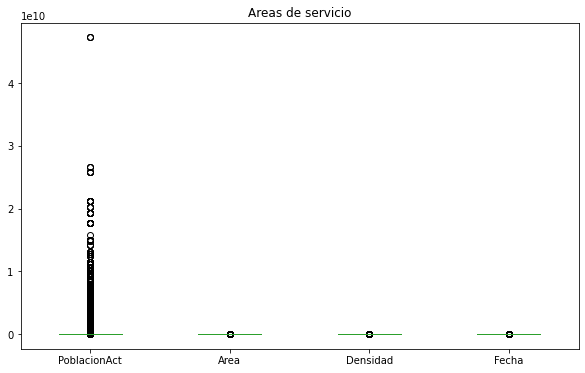

Histogramas para 'Areas de servicio':


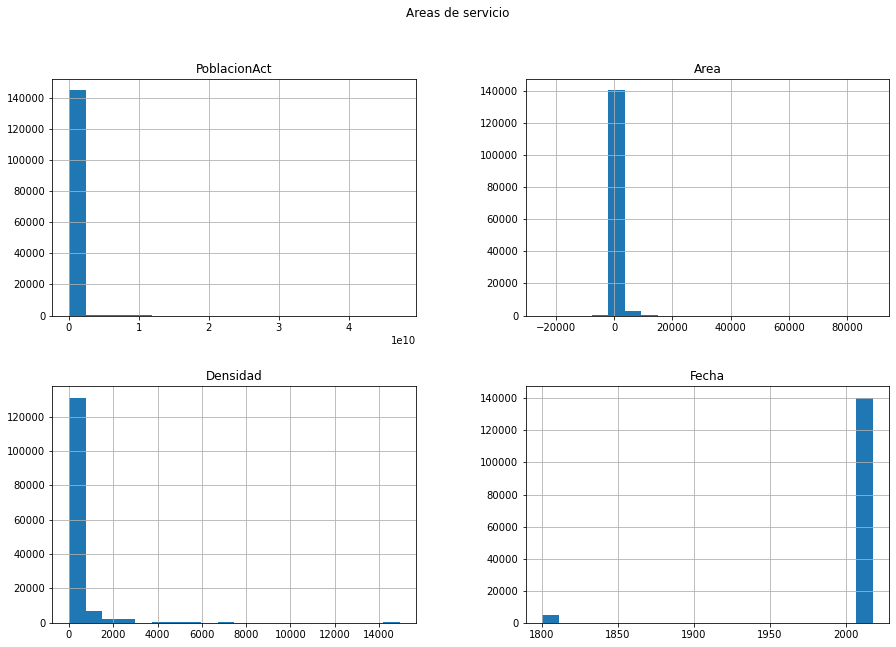

Matriz de correlación para 'Areas de servicio':


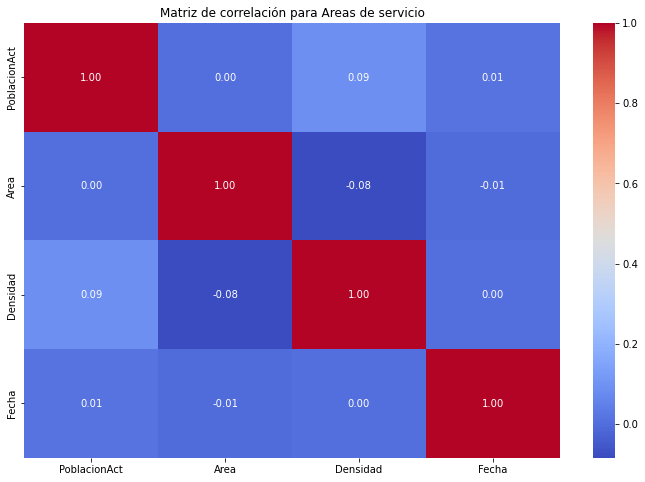

Diagrama de cajas y bigotes para 'Condiciones de pago':
No hay columnas numéricas para mostrar en 'Condiciones de pago'.
Histogramas para 'Condiciones de pago':
No hay columnas numéricas para mostrar en 'Condiciones de pago'.
Matriz de correlación para 'Condiciones de pago':
No hay columnas numéricas para mostrar en 'Condiciones de pago'.
Diagrama de cajas y bigotes para 'Planes beneficio':


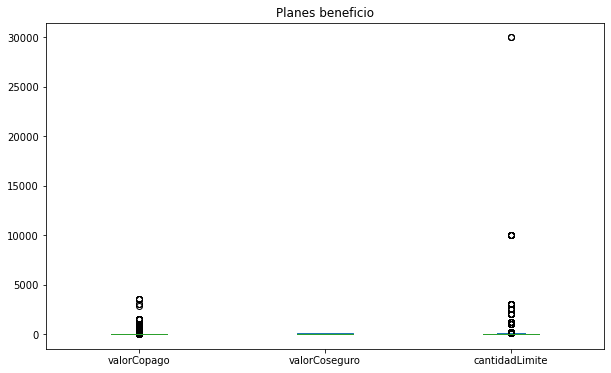

Histogramas para 'Planes beneficio':


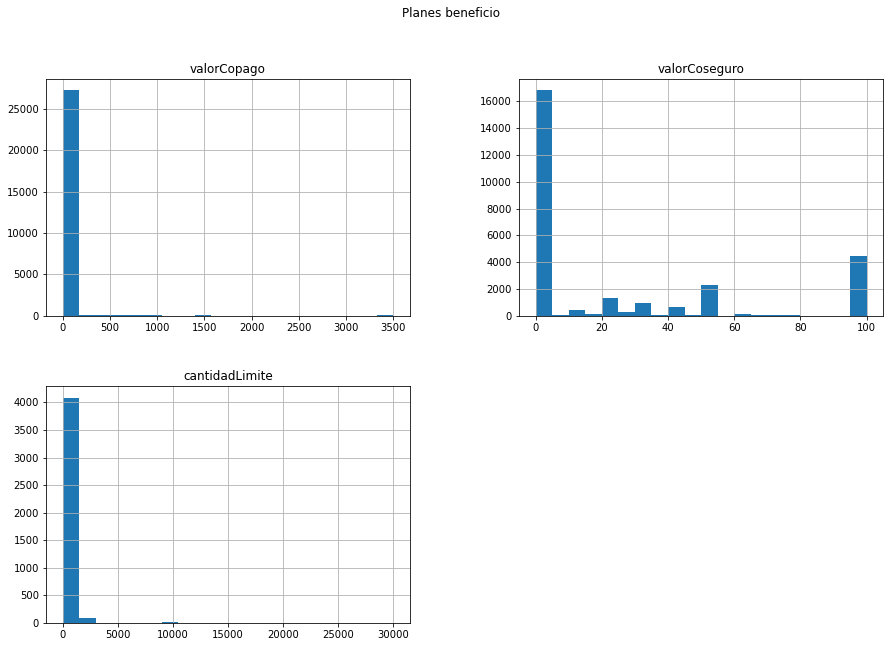

Matriz de correlación para 'Planes beneficio':


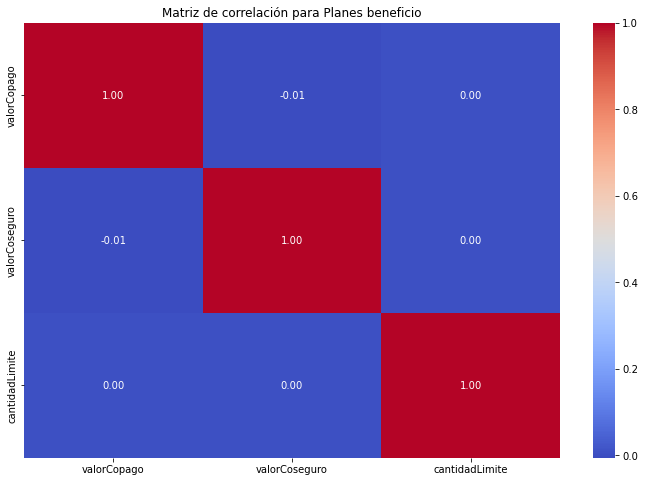

Diagrama de cajas y bigotes para 'Tipos de beneficio':


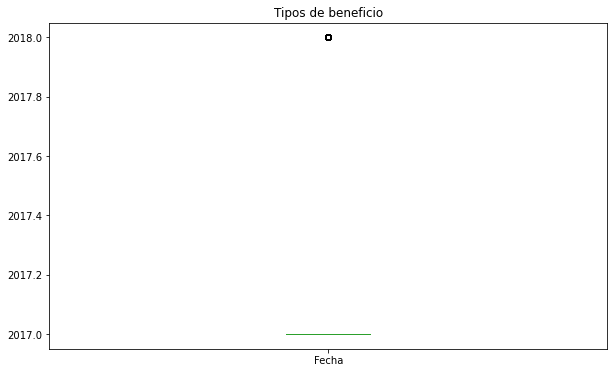

Histogramas para 'Tipos de beneficio':


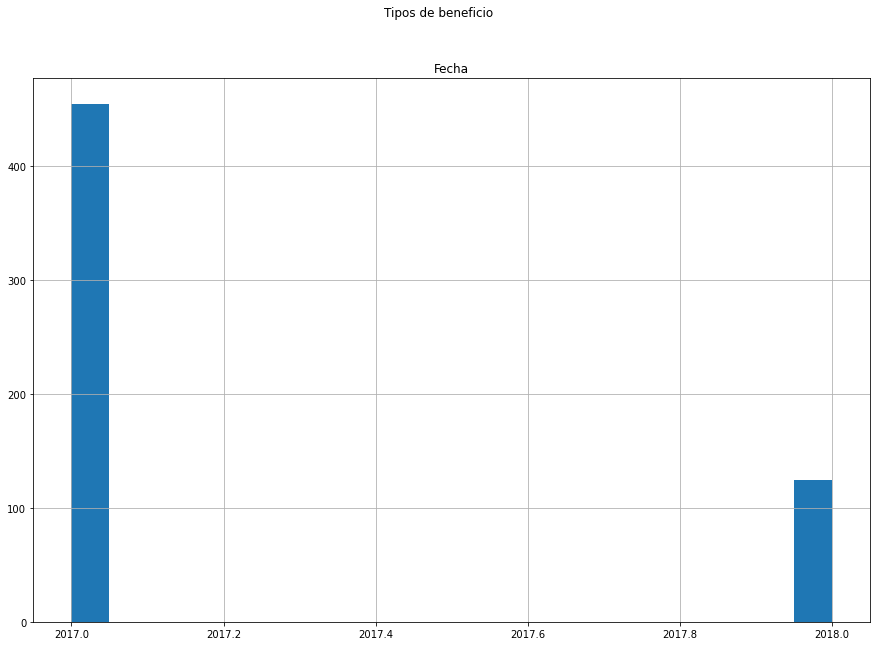

Matriz de correlación para 'Tipos de beneficio':


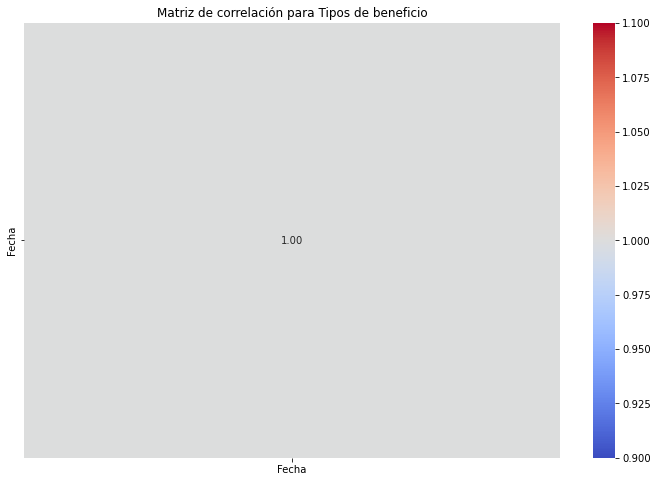

In [89]:
# Diagramas de Cajas y Bigotes, Histogramas y Matriz de Correlación
for nombre, df in tablas.items():
    print(f"Diagrama de cajas y bigotes para '{nombre}':")
    plot_boxplot(df, nombre)
    print(f"Histogramas para '{nombre}':")
    plot_histogram(df, nombre)
    print(f"Matriz de correlación para '{nombre}':")
    plot_correlation_matrix(df, nombre)

###### Tabla Areas de servicio: 
* Diagrama Cajas  y Bigotes: El diagrama de cajas y bigotes inicial indica una gran variabilidad y presencia de valores atípicos en los datos justamente por la variable "PoblacionAct"
 
* Histogramas:
 * PoblacionAct: La mayoría de las áreas tienen poblaciones bajas, con muy pocos casos de áreas con poblaciones extremadamente altas. 
 * Area: La mayoría de las áreas tienen tamaños pequeños, con muy pocos casos de áreas extremadamente grandes.
 * Densidad: La densidad de población en la mayoría de las áreas es baja, con algunos casos de densidades extremadamente altas.
 * Fecha: La mayoría de los registros están concentrados en los años recientes.

* Matriz de correlación:
 * PoblacionAct: Correlación positiva débil con Area (0.09).
 * Area: Correlación negativa débil con Densidad.
 * Densidad: Correlación negativa débil.
 * Fecha: Correlación insignificante con todas las demás variables.
 

###### Planes beneficio: 

* Diagrama Cajas  y Bigotes:
 * ValorCopago: La mayoría de los datos están concentrados en la parte baja, con varios outliers hacia la derecha.
 * ValorCoseguro: La caja es pequeña, indicando poca variabilidad en los datos de área.
 * Cantidadlimite: Existen valores atípicos que son significativamente mayores que la mayoría de los datos, indicando algunos planes con límites de cantidad excepcionalmente altos.
 
* Histogramas: 
 * valorCopago: La mayoría de los valores están cerca de cero, con una cola que se extiende hacia la derecha. Esto indica que la mayoría de los planes tienen un copago bajo, pero hay algunos planes con copagos significativamente más altos.
 * valorCoseguro: La distribución es muy similar a la de valorCopago, con la mayoría de los valores concentrados cerca de cero.
 * cantidadLimite: la mayoría de los valores están cerca de cero, con algunos valores excepcionalmente altos.

* Matriz de correlación:
 * valorCopago: No muestra una correlación significativa con valorCoseguro (-0.01) ni con cantidadLimite (0.00).
 * valorCoseguro: Similar a valorCopago, valorCoseguro no muestra una correlación significativa con cantidadLimite (0.00)
 * cantidadLimite: No muestra correlaciones significativas con ninguna otra variable, indicando que los límites de cantidad no están relacionados con los valores de copago o coseguro.
 

Análisis 1.a: Dado un proveedor o grupo de proveedores, identificar si tiene o ha tenido un comportamiento desleal.

Se puede tomar la tabla planes_beneficio, donde la columna IdProveedor_T en la tabla planes_beneficio permite identificar los planes ofrecidos por un proveedor específico y la columna IdTipoBeneficio_T permite comparar los valores de copago y coseguro para el mismo tipo de beneficio.

Análisis 1.b: Dado un rango de fechas, identificar proveedores con comportamientos desleales.

Se puede tomar la tabla planes_beneficio, donde la columna Fecha permite filtrar los datos por el rango de fechas especificado.
La columna IdProveedor_T permite identificar los planes ofrecidos por un proveedor específico dentro del rango de fechas.
La columna IdTipoBeneficio_T permite comparar los valores de copago y coseguro para el mismo tipo de beneficio.

* Se asume que la columna Fecha está en el formato YYYY-MM-DD.
* Se asume que todos los planes y beneficios están registrados en la base de datos.

Preguntas al negocio:
* Rango de Fechas: ¿Debe el rango de fechas incluir tanto el inicio como el fin de la fecha proporcionada?
* ¿Cómo deben manejarse los valores nulos en las columnas valorCopago y valorCoseguro?
* ¿Se deben considerar valores atípicos en los análisis de copago y coseguro?

Ajustes convenientes a realizar: 
* Verificar y asegurar que la columna Fecha esté en el formato correcto en todas las tablas.
* Decidir cómo manejar los valores nulos en las columnas valorCopago y valorCoseguro. Se puede optar por eliminar registros nulos o imputar valores según criterios específicos.


Análisis 2.a: Nivel de Cobertura de los Planes con Respecto a las Áreas de Servicio
Se puede utilizar las tablas areas_servicio y planes_beneficio con las columnas IdAreaDeServicio_T y Fecha en ambas tablas.

Análisis 2.b: Cobertura Total de los Proveedores
Se pueden utilizar las columnas IdProveedor_T, IdAreaDeServicio_T, y Fecha en la tabla planes_beneficio.

Análisis 2.c: Áreas de Servicios Cubiertas por Menos de Dos Proveedores
Se pueden utilizar las columnas IdAreaDeServicio_T, IdProveedor_T, y Fecha en la tabla planes_beneficio.

Preguntas al negocio:

* ¿La cobertura total se refiere a que cada área de servicio debe estar cubierta por al menos un plan en cada año, o solo una vez en el rango de años?
* ¿La fecha en planes_beneficio se refiere al año en el que el plan está activo, y debe considerarse así para todos los análisis?


Análisis 3.a:Dado un rango de años, identificar cuántos y cuáles planes hay por áreas de servicio 
Es posible con las columnas IdAreaDeServicio_T, NombreAreaDeServicio, Fecha, IdPlan_T de las tablas areas_servicio y planes_beneficio.

Análisis 3.b:  Identificar áreas con concentraciones de planes que no correspondan con la cantidad de habitantes
Es posible con las mismas columnas, añadiendo el cálculo de la relación planes/población y su comparación con la media y desviación estándar.

Preguntas al negocio:
* ¿Cómo manejar áreas de servicio con poblaciones extremadamente pequeñas o grandes?

Análisis 4.a: Evolución de los Costos y Tipos de Beneficios a lo Largo del Tiempo
Con las tablas planes_beneficio y tipos_beneficio y las columnas IdTipoBeneficio_T, Nombre, IdProveedor_T, Fecha, valorCopago, valorCoseguro

Análisis 4.b: Identificar Tipos de Beneficios que Han Aumentado o Disminuido Costos
Es posible con las mismas columnas, añadiendo el cálculo del cambio en los costos al inicio y al final del rango de fechas.

Ajustes convenientes:
Se deben especificar los tipos de beneficios para el análisis.